In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 4118
Neutral : 35704
Negative : 326


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  862


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Nature/Parks'][df1['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Day trip to the Semien mountain has been a transformative experience as the '
 'stark contrast between the deep valleys!']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['day', 'trip', 'to', 'the', 'semien', 'mountain', 'has', 'been', 'transformative', 'experience', 'as', 'the', 'stark', 'contrast', 'between', 'the', 'deep', 'valleys']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['day', 'trip', 'to', 'the', 'semien', 'mountain', 'has', 'been', 'transformative', 'experience', 'as', 'the', 'stark', 'contrast', 'between', 'the', 'deep', 'valleys']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['day', 'trip', 'transformative', 'experience', 'stark', 'contrast', 'deep', 'valley']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('contrast', 1),
  ('day', 1),
  ('deep', 1),
  ('experience', 1),
  ('stark', 1),
  ('transformative', 1),
  ('trip', 1),
  ('valley', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.127*"hide" + 0.045*"vehicle" + 0.045*"drop" + 0.045*"pick" + '
  '0.045*"price" + 0.045*"headquarters" + 0.045*"path" + 0.045*"dream" + '
  '0.045*"ranger" + 0.045*"gem"'),
 (1,
  '0.054*"equal" + 0.054*"know" + 0.054*"zebra" + 0.054*"lesser" + '
  '0.054*"walk" + 0.054*"see" + 0.054*"season" + 0.054*"wet" + 0.054*"least" + '
  '0.054*"long"'),
 (2,
  '0.109*"experience" + 0.109*"wildlife" + 0.108*"small" + 0.057*"abundance" + '
  '0.057*"see" + 0.057*"late" + 0.005*"hide" + 0.005*"expensive" + '
  '0.005*"much" + 0.005*"long"'),
 (3,
  '0.043*"plague" + 0.043*"human" + 0.043*"show" + 0.043*"become" + '
  '0.043*"hippos" + 0.043*"savannah" + 0.043*"prepared" + 0.043*"taste" + '
  '0.043*"pod" + 0.043*"little"'),
 (4,
  '0.048*"hide" + 0.047*"unbelievable" + 0.047*"highland" + 0.047*"scout" + '
  '0.047*"job" + 0.047*"hardest" + 0.047*"performance" + 0.047*"can" + '
  '0.047*"view" + 0.047*"town"'),
 (5,
  '0.137*"expensive" + 0.072*"quite" + 0.072*"trip" + 0.072*"unbelievable

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.00212645381689

Coherence Score:  0.7009890092342378


In [17]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('valley', 0.1111111111111111),
   ('transformative', 0.1111111111111111),
   ('path', 0.1111111111111111),
   ('taste', 0.1111111111111111),
   ('job', 0.1111111111111111),
   ('hippos', 0.1111111111111111),
   ('abusive', 0.1111111111111111),
   ('show', 0.1111111111111111),
   ('stark', 0.1111111111111111),
   ('lesser', 0.0)]),
 (1,
  [('trip', 0.1),
   ('tour', 0.1),
   ('leg', 0.1),
   ('zebra', 0.1),
   ('dangerous', 0.1),
   ('weather', 0.1),
   ('tourism', 0.1),
   ('management', 0.1),
   ('experience', 0.1),
   ('temporarily', 0.1)]),
 (2,
  [('small', 0.3333333333333333),
   ('kid', 0.1111111111111111),
   ('view', 0.1111111111111111),
   ('region', 0.1111111111111111),
   ('baboon', 0.1111111111111111),
   ('tour', 0.1111111111111111),
   ('pick', 0.1111111111111111),
   ('know', 0.0),
   ('equal', 0.0),
   ('path', 0.0)]),
 (3,
  [('avoid', 0.21428571428571427),
   ('dramatic', 0.07142857142857142),
   ('hide', 0.07142857142857142),
   ('african', 0.071428571428571

2
3
4
5
6
7
8
9
10


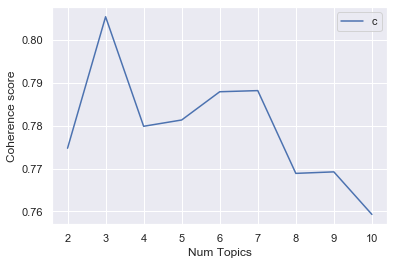

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7747
Num Topics = 3  has Coherence Value of 0.8053
Num Topics = 4  has Coherence Value of 0.7798
Num Topics = 5  has Coherence Value of 0.7813
Num Topics = 6  has Coherence Value of 0.7879
Num Topics = 7  has Coherence Value of 0.7881
Num Topics = 8  has Coherence Value of 0.7689
Num Topics = 9  has Coherence Value of 0.7692
Num Topics = 10  has Coherence Value of 0.7593


In [22]:
optimal_model = model_list[1] # Number of Topics = 3

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.111*"hide" + 0.083*"small" + 0.056*"unbelievable" + 0.028*"job" + '
  '0.028*"path" + 0.028*"region" + 0.028*"equal" + 0.028*"view" + '
  '0.028*"lesser" + 0.028*"dangerous"'),
 (1,
  '0.083*"experience" + 0.062*"wildlife" + 0.062*"avoid" + 0.042*"expensive" + '
  '0.021*"rough" + 0.021*"dramatic" + 0.021*"report" + 0.021*"authority" + '
  '0.021*"abundance" + 0.021*"gem"'),
 (2,
  '0.129*"long" + 0.065*"day" + 0.065*"trip" + 0.032*"dream" + 0.032*"tourist" '
  '+ 0.032*"naughty" + 0.032*"tough" + 0.032*"culture" + 0.032*"discover" + '
  '0.032*"season"')]


In [23]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.358759 -0.164201       1        1  33.933656
0     -0.333176 -0.205172       2        1  33.255053
2     -0.025583  0.369372       3        1  32.811291, topic_info=   Category      Freq          Term     Total  loglift  logprob
16  Default  5.000000          long  5.000000  30.0000  30.0000
46  Default  4.000000          hide  4.000000  29.0000  29.0000
3   Default  3.000000    experience  3.000000  28.0000  28.0000
42  Default  3.000000         small  3.000000  27.0000  27.0000
1   Default  2.000000           day  2.000000  26.0000  26.0000
6   Default  2.000000          trip  2.000000  25.0000  25.0000
25  Default  2.000000      wildlife  2.000000  24.0000  24.0000
59  Default  2.000000         avoid  2.000000  23.0000  23.0000
74  Default  2.000000  unbelievable  2.000000  22.0000  22.0000
14  Default  1.000000     expensive  1.000000  21.0000  21.0000
21  Default  1.000000         tough  1.000000  20.0000  20.0000
71  Default  1.000000         dream  1.000000  19.0000  19.0000
47  Default  1.000000       culture  1.000000  18.0000  18.0000
96  Default  1.000000   atmospheric  1.000000  17.0000  17.0000
38  Default  1.000000       typical  1.000000  16.0000  16.0000
54  Default  1.000000          road  1.000000  15.0000  15.0000
82  Default  1.000000       hardest  1.000000  14.0000  14.0000
20  Default  1.000000       naughty  1.000000  13.0000  13.0000
15  Default  1.000000          time  1.000000  12.0000  12.0000
78  Default  1.000000          walk  1.000000  11.0000  11.0000
17  Default  1.000000           run  1.000000  10.0000  10.0000
48  Default  1.000000       tourist  1.000000   9.0000   9.0000
11  Default  1.000000         price  1.000000   8.0000   8.0000
34  Default  1.000000         worth  1.000000   7.0000   7.0000
8   Default  1.000000          drop  1.000000   6.0000   6.0000
73  Default  1.000000     appalling  1.000000   5.0000   5.0000
66  Default  1.000000          late  1.000000   4.0000   4.0000
43  Default  1.000000      discover  1.000000   3.0000   3.0000
49  Default  1.000000      criminal  1.000000   2.0000   2.0000
84  Default  1.000000           job  1.000000   1.0000   1.0000
..      ...       ...           ...       ...      ...      ...
11   Topic3  1.375957         price  1.375957   1.1144  -3.4340
15   Topic3  1.375957          time  1.375957   1.1144  -3.4340
16   Topic3  5.503829          long  5.503829   1.1144  -2.0477
17   Topic3  1.375957           run  1.375957   1.1144  -3.4340
20   Topic3  1.375957       naughty  1.375957   1.1144  -3.4340
21   Topic3  1.375957         tough  1.375957   1.1144  -3.4340
34   Topic3  1.375957         worth  1.375957   1.1144  -3.4340
38   Topic3  1.375957       typical  1.375957   1.1144  -3.4340
43   Topic3  1.375957      discover  1.375957   1.1144  -3.4340
47   Topic3  1.375957       culture  1.375957   1.1144  -3.4340
48   Topic3  1.375957       tourist  1.375957   1.1144  -3.4340
49   Topic3  1.375957      criminal  1.375957   1.1144  -3.4340
54   Topic3  1.375957          road  1.375957   1.1144  -3.4340
66   Topic3  1.375957          late  1.375957   1.1144  -3.4340
71   Topic3  1.375957         dream  1.375957   1.1144  -3.4340
73   Topic3  1.375957     appalling  1.375957   1.1144  -3.4340
78   Topic3  1.375957          walk  1.375957   1.1144  -3.4340
1    Topic3  2.751915           day  2.751915   1.1144  -2.7408
35   Topic3  1.375957         drive  2.294994   0.6028  -3.4340
29   Topic3  1.375957         guide  2.294994   0.6028  -3.4340
39   Topic3  1.375957        season  2.576834   0.4870  -3.4340
64   Topic3  1.375957          tour  2.576834   0.4870  -3.4340
0    Topic3  0.000000      contrast  0.919037     -inf     -inf
2    Topic3  0.000000          deep  0.919037     -inf     -inf
3    Topic3  0.000000    experience  3.676146     -inf     -inf
4    Topic3  0.000000         stark  1.

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3391,"hide, small, unbelievable, job, path, region, ...",Day trip to the Semien mountain has been a tra...
1,1,0.0,0.3394,"hide, small, unbelievable, job, path, region, ...",Simien Mountain park headquarters outrageous v...
2,2,0.0,0.3333,"hide, small, unbelievable, job, path, region, ...",Decent; Not Spectacular
3,3,1.0,0.3464,"experience, wildlife, avoid, expensive, rough,...",A Must for Active Souls
4,4,0.0,0.3333,"hide, small, unbelievable, job, path, region, ...",Not interesting
5,5,1.0,0.3464,"experience, wildlife, avoid, expensive, rough,...",Expensive
6,6,2.0,0.3464,"long, day, trip, dream, tourist, naughty, toug...",Waste of Time
7,7,1.0,0.3464,"experience, wildlife, avoid, expensive, rough,...",Terrible experience with tour guide Mamo
8,8,2.0,0.3590,"long, day, trip, dream, tourist, naughty, toug...",Long run
9,9,0.0,0.3522,"hide, small, unbelievable, job, path, region, ...",watchout for baboons and naughty kids


In [25]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    28
1.0    18
2.0    12
Name: Dominant_Topic, dtype: int64

In [26]:
df_dominant_topic.to_csv('ethiopia_442.csv', index = False)

In [27]:
# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Topicless/Unidentifiable - 28
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Expensive Fees - 18
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Accessibility Criticism - 12

In [28]:
# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Expressing Disappointment - 20
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Expensive Fees - 14
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # General Criticism - 7
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # General Criticism - 7
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Criticism - 10

In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3590,"hide, small, unbelievable, job, path, region, ...",Lesser-known than Simien but at least equal
1,1.0,0.3831,"experience, wildlife, avoid, expensive, rough,...",Avoid! avoid! Avoid! Abusive and DANGEROUS Gui...
2,2.0,0.3590,"long, day, trip, dream, tourist, naughty, toug...",Long run


In [30]:
sent_topics_sorteddf_mallet['Text'].values

array(['Lesser-known than Simien but at least equal',
       'Avoid! avoid! Avoid! Abusive and DANGEROUS Guide! Reported to the Authorities in Ethiopia -',
       'Long run'], dtype=object)

In [31]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics